<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/master/nb/HOD_HMC_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling HOD parameters by Hamiltonian Monte-Carlo

Authors:
 - [@bhorowitz](https://github.com/bhorowitz) (Ben Horowitz)
 - [@EiffL](https://github.com/EiffL) (Francois Lanusse)


This notebook demonstrate sampling HOD parameters using HMC over a stochastically sampled galaxy catalogs.




## Setup

Here we quickly install our dependencies, and download the reference halotools 
catalog from the Bolshoi simulation. This takes under a minute.

#!pip install --quiet -i https://test.pypi.org/simple/ halotools
#!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/DHOD.git

#!download_initial_halocat.py

In [1]:
%pylab inline
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi


Tue Oct 25 02:02:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   35C    P8     1W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   

In [3]:
!nvidia-smi
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

Tue Oct 25 02:03:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   35C    P8     1W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 17%   

In [4]:
import tensorflow as tf
import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
from diffhod.utils import cic_paint
from diffhod.mock_observables.pk import Power_Spectrum

2022-10-25 02:03:07.746266: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 02:03:08.810879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30997 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:22:00.0, compute capability: 7.0


In [5]:
from diffhod.components import _Zheng07SatsRate

In [6]:
import tensorflow_probability as tfp

In [7]:
# A few hyper parameters
temperature=0.1
batch_size=5
max_sat=48
box_size = 128.

fid_params = tf.convert_to_tensor([12.02, 0.26, 11.38, 13.31, 1.06])

In [8]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos, and restricting the size of the catalog
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < box_size]
halo_table = halo_table[halo_table['halo_y'] < box_size]
halo_table = halo_table[halo_table['halo_z'] < box_size]
print("Size of halo catalog", len(halo_table))

# Convert table to tensors
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

Size of halo catalog 139905


In [9]:
# Here is how we define the same model in
@tf.function
def hod(halo_cat, 
        logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,batch_size=batch_size):
  
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temperature)
  
  n_sat = Zheng07Sats(halo_cat['halo_mvir'],
                      n_cen,
                      logM0=logM0,
                      logM1=logM1,
                      alpha=alpha,
                      sample_shape=(max_sat,),
                      temperature=temperature)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                       halo_cat['halo_y'],
                                       halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                       concentration=halo_cat['halo_nfw_conc'],
                       Rvir=halo_cat['halo_rvir'],
                       sample_shape=(max_sat, batch_size))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat, 'n_sat':n_sat}

In [10]:
import tensorflow as tf


#TF2 compatable painter
@tf.function  #(experimental_relax_shapes=True)
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(
        tf.constant([[[0, 0, 0], [1., 0, 0], [0., 1, 0], [0., 0, 1], [1., 1, 0],
                      [1., 0, 1], [0., 1, 1], [1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None:
      kernel = tf.multiply(tf.expand_dims(weight, axis=-1), kernel)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    b = tf.cast(b, tf.float32)
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    update = tf.scatter_nd(
        tf.reshape(neighboor_coords, (-1, 8, 4)), tf.reshape(kernel, (-1, 8)),
        [batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh


In [11]:
#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=128):
  # Take centrals and rescale them to the boxsize
  bs = gal_cat['n_sat'].shape[1]

  # Convert to mesh pixel coordinate
  sample1 = gal_cat['pos_cen'] / box_size * nc
  weights1 = gal_cat['n_cen']
  sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])

  # Take sats and rescale them to the boxize
  sample2 = gal_cat['pos_sat'] / box_size * nc
  weights2 = gal_cat['n_sat']
  # Swapping sample dimension and batch dimension
  sample2 = tf.transpose(sample2, [1,0,2,3])
  weights2 = tf.transpose(weights2, [1,0,2])
  # Reshaping
  sample2 = tf.reshape(sample2, [bs, -1, 3])
  weights2 = tf.reshape(weights2, [bs, -1])
  
  rho = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
  rho = cic_paint(rho, sample2, weights2)

  return rho

In [12]:
gal_cat = hod(tf_halocat, 
              logMmin=tf.constant([11,12,13,14,15],dtype=tf.float32),
              sigma_logM=0.26*tf.ones([batch_size]), 
              logM0=11.38*tf.ones([batch_size]), 
              logM1=13.31*tf.ones([batch_size]), 
              alpha=1.06*tf.ones([batch_size]))

2022-10-25 02:03:15.441448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
density = paint_galaxies(gal_cat)

11


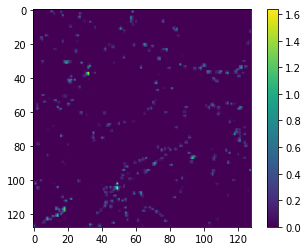

12


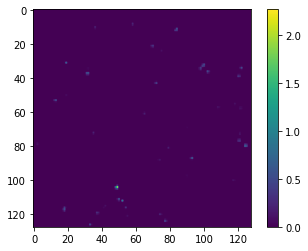

13


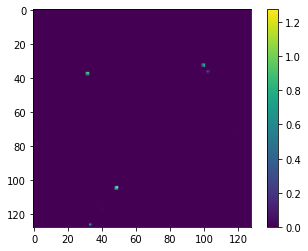

14


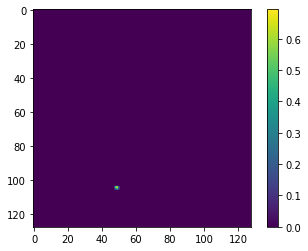

15


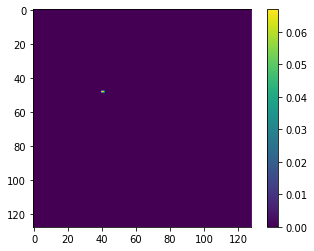

In [14]:
for i in range(0,5):
    print(11+i)
    imshow(density[i,0])
    colorbar()
    show()

In [15]:
var = tf.convert_to_tensor([15.02,11.0])

In [16]:
var.shape

TensorShape([2])

In [17]:
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    batch_size = logMmin.shape[0]
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha,batch_size=batch_size))

In [18]:
#check all variables for batch-ness
rho = sample(tf_halocat, 
             tf.convert_to_tensor([15.02,11.0]),
             tf.convert_to_tensor([0.26,0.22]), 
             tf.convert_to_tensor([10.0,11.]), 
             tf.convert_to_tensor([10.31,12.0]), 
             tf.convert_to_tensor([1.06,1.06]))

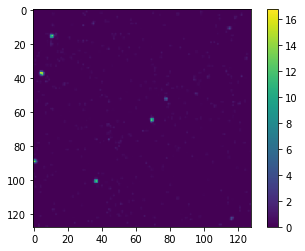

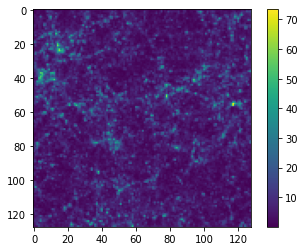

In [19]:
imshow(np.array(rho[0]).sum(axis=0))
colorbar()
show()
imshow(np.array(rho[1]).sum(axis=0))
colorbar()
show()

In [20]:
# Let's now build a function that returns a sampled power spectrum
PS = Power_Spectrum(shape=np.array([box_size, box_size, box_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=0.1,dk=.05)

@tf.function
def get_pk(halocat, logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06):
    k, pk = PS.pk_tf(sample(tf_halocat, logMmin=logMmin, sigma_logM=sigma_logM,
                            logM0=logM0, logM1=logM1, alpha=alpha))
    return k, pk

In [21]:
k, pk = get_pk(tf_halocat, 
             tf.convert_to_tensor([15.02,11.0]),
             tf.convert_to_tensor([0.26,0.22]), 
             tf.convert_to_tensor([10.0,11.]), 
             tf.convert_to_tensor([10.31,12.0]), 
             tf.convert_to_tensor([1.06,1.06]))

Instructions for updating:
Use fn_output_signature instead


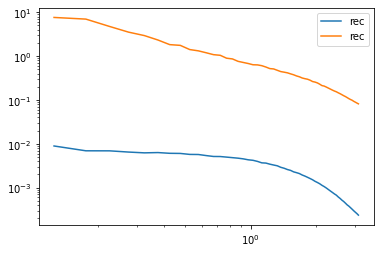

In [22]:
loglog(k,pk[0], label='rec')
loglog(k,pk[1], label='rec')
legend()

# Let's just compute a diagonal cov (takes a while...)
import time
start_time = time.time()
samps = []
for i in range(50):
  k, pk = get_pk(tf_halocat, 
                logMmin=12.02*tf.ones([batch_size]),
                sigma_logM=0.26*tf.ones([batch_size]), 
                logM0=11.38*tf.ones([batch_size]), 
                logM1=13.31*tf.ones([batch_size]), 
                alpha=1.06*tf.ones([batch_size]))
  samps.append(pk)
end_time = time.time()- start_time
print(end_time)

#samps = np.stack(samps, axis=0).reshape(100,-1)
sampls = np.load()
diag_std = samps.std(axis=0)
mean = samps.mean(axis=0)

loglog(diag_std)
loglog(mean)

In [23]:
mean = np.load("mean.npy")
cov = np.load("cov_use.npy")

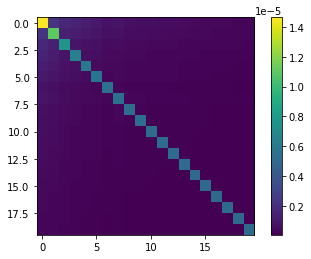

In [24]:
imshow(cov)
colorbar()

In [25]:
cov

array([[1.46454377e-05, 2.25357576e-06, 1.74495619e-06, 1.44620128e-06,
        1.22699066e-06, 1.05351523e-06, 7.87718761e-07, 8.79475749e-07,
        6.64889228e-07, 6.30681939e-07, 5.82625262e-07, 5.57950102e-07,
        5.37535811e-07, 4.90753507e-07, 4.48304149e-07, 3.91629300e-07,
        3.80720763e-07, 3.51906635e-07, 3.46806587e-07, 3.33052753e-07],
       [2.25357576e-06, 1.10116353e-05, 1.35884648e-06, 1.21732614e-06,
        1.03382990e-06, 8.69493761e-07, 6.83636529e-07, 7.09281437e-07,
        5.54539554e-07, 5.50511118e-07, 4.78676100e-07, 4.62563520e-07,
        4.43570229e-07, 4.13912346e-07, 3.78107870e-07, 3.48948248e-07,
        3.28392105e-07, 3.14431276e-07, 3.07746916e-07, 3.00629893e-07],
       [1.74495619e-06, 1.35884648e-06, 7.64179094e-06, 9.12912014e-07,
        7.68390464e-07, 6.96110931e-07, 5.01687680e-07, 5.50041875e-07,
        4.55725797e-07, 4.43780095e-07, 3.92128953e-07, 3.63045132e-07,
        3.58610180e-07, 3.20096689e-07, 2.96586563e-07, 2.6899

In [26]:
np.diag(cov)

array([1.4645438e-05, 1.1011635e-05, 7.6417909e-06, 6.4040260e-06,
       5.9737877e-06, 5.7094667e-06, 5.4174307e-06, 5.4475117e-06,
       5.2886867e-06, 5.2665105e-06, 5.2085979e-06, 5.1835200e-06,
       5.1763177e-06, 5.1380230e-06, 5.1191764e-06, 5.1036682e-06,
       5.0911153e-06, 5.0839158e-06, 5.0776330e-06, 5.0696408e-06],
      dtype=float32)

In [27]:
cov.shape,mean.shape

((20, 20), (20,))

In [28]:
# This is not the right way to do this with edward, but...
import tensorflow_probability as tfp 
tfd = tfp.distributions

p = tf.tile(tf.expand_dims(fid_params,0), [batch_size, 1])
#ogMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06)

prior_loc = [12.00, 0.25, 11.25, 13.20, 01.00]#[12,0.25]
prior_width = [1/2,1/5,1/2,1/2,1/5]
def log_prob_fn(params):
    k, pk = get_pk(tf_halocat, 
              logMmin=params[:,0],
              sigma_logM=params[:,1], 
              logM0=params[:,2], 
              logM1=params[:,3], 
              alpha=params[:,4])

    prior = tfp.distributions.MultivariateNormalDiag(loc = prior_loc, scale_diag=prior_width).log_prob(params)
    print(prior)
    return prior+tfp.distributions.MultivariateNormalFullCovariance(loc=mean,covariance_matrix=cov+ 8.0*10**-5*np.eye(20,20,dtype=np.float32)).log_prob(pk[:,:20])#tfd.MultivariateNormalDiag(loc=mean,scale_diag=diag_std).log_prob(pk)/25

 # print(pk.shape)
  #return tfd.MultivariateNormalFullCovariance(loc=mean,covariance_matrix=cov + 1.0*10**-5*np.eye(20,20,dtype=np.float32)).log_prob(pk[:,:20])



In [29]:
log_prob_fn( tf.convert_to_tensor([[12.02, 0.26, 11.38, 13.31, 1.0],[13.02, 0.26, 11.38, 13.31, 1.0]]))

#log_prob_fn( tf.convert_to_tensor([[12.02, 0.26],[13.02, 0.26]]))

tf.Tensor([ 0.6435747 -1.4364276], shape=(2,), dtype=float32)
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


2022-10-25 02:03:30.463641: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x556bb6568c20


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 75.68288 , -10.540501], dtype=float32)>

In [30]:


num_burnin_steps = int(1)#3e1) #oops....
num_chains = 3

#adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
#    tfp.mcmc.HamiltonianMonteCarlo(
#        target_log_prob_fn=log_prob_fn,
#        num_leapfrog_steps=4,
#        step_size=.03), #can play a lot with this number...
#    num_adaptation_steps=int(num_burnin_steps * 0.8))


#alternative HMC NUTS kernel...
kernel = tfp.mcmc.NoUTurnSampler(log_prob_fn, step_size=0.1)
adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    kernel,
    num_adaptation_steps=10,
    # pkr: previous kernel results, new_ss: new step size
    step_size_setter_fn=lambda pkr, new_ss: pkr._replace(step_size=new_ss),
    step_size_getter_fn=lambda pkr: pkr.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
)

In [31]:
#start spread out around some point
#var = (np.random.random([num_chains, 5])-0.5)*np.array([0.1,0.02,0.01,0.1,0.01])*0.010
var1 = (np.random.random([num_chains, 5])-0.5)*np.array([0.1])*0.10

In [32]:
num_results = 800

# Initial state of the chain [12.12, 0.36, 10.36, 13.21, 1.16]
init_state = tf.Variable(np.ones([num_chains, 1], dtype=dtype)*np.array([12.12,0.2,11.28, 13.31, 01.000100],dtype=float32)+var1,dtype=float32)



In [33]:
tfp.math.value_and_gradient(lambda x: log_prob_fn(x), [init_state])


tf.Tensor([0.6208706 0.6120696 0.6133084], shape=(3,), dtype=float32)


(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([67.8756  , 66.417625, 65.94758 ], dtype=float32)>,
 [<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
  array([[ -99.871025 ,   14.26483  ,   -1.5396018,  -89.778    ,
            32.655636 ],
         [-107.76685  ,   21.895117 ,   -1.4067383,  -90.200165 ,
            36.366608 ],
         [-111.27696  ,   21.679422 ,   -1.5944495,  -91.57747  ,
            32.46531  ]], dtype=float32)>])

In [34]:
tfp.math.value_and_gradient(lambda a,b,c,d: _Zheng07SatsRate(a,b,c,d), [10**11.0,12.0,10.0,00.990])

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=-0.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=-0.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>])

In [35]:
init_state
#log_prob_fn(init_state)

<tf.Variable 'Variable:0' shape=(3, 5) dtype=float32, numpy=
array([[12.117878  ,  0.2034155 , 11.278996  , 13.314356  ,  0.99969286],
       [12.1249485 ,  0.19648756, 11.276463  , 13.30739   ,  0.99763083],
       [12.118554  ,  0.19534317, 11.281157  , 13.306996  ,  0.9985482 ]],
      dtype=float32)>

In [36]:
@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_state,
      kernel=adaptive_kernel,#adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    return samples,is_accepted#sample_mean, sample_stddev, is_accepted

In [ ]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Tensor("mcmc_sample_chain/dual_averaging_step_size_adaptation___init__/_bootstrap_results/NoUTurnSampler/.bootstrap_results/process_args/maybe_call_fn_and_grads/value_and_gradients/mcmc_sample_chain_dual_averaging_step_size_adaptation___init____bootstrap_results_NoUTurnSampler_bootstrap_results_process_args_maybe_call_fn_and_grads_value_and_gradients_MultivariateNormalDiag/log_prob/add:0", shape=(3,), dtype=float32)
Tensor("mcmc_sample_chain/dual_averaging_step_size_adaptation___init__/_bootstrap_results/NoUTurnSampler/.bootstrap_results/process_args/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/mcmc_sample_chain_dual_averaging_step_size_adaptation___init____bootstrap_results_NoUTurnSampler_bootstrap_results_process_args_maybe_call_fn_and_grads_value_and_gradients_value_and_gradient_MultivariateNormalDiag/log_prob/add:0", shape=(3,), dtype=float32

In [39]:
np.save("HMC_Samples_5D_R1B_1028.npy",np.array(q[:,:,:]))

In [40]:
print(run_time/60)

5921.411221428712


In [41]:
q[0]-q[-1]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[-0.02212906, -0.08697049,  0.5678215 ,  0.20432663,  0.08294916],
       [-0.10086823, -0.19934423, -0.02837181,  0.32268906,  0.22143608],
       [ 0.11214924,  0.15684997, -0.44087315,  0.06192875, -0.14262182]],
      dtype=float32)>

In [42]:
is_accepted

<tf.Tensor: shape=(800, 3), dtype=bool, numpy=
array([[False, False, False],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])>

In [43]:
q

<tf.Tensor: shape=(800, 3, 5), dtype=float32, numpy=
array([[[12.117878  ,  0.2034155 , 11.278996  , 13.314356  ,
          0.99969286],
        [12.1249485 ,  0.19648756, 11.276463  , 13.30739   ,
          0.99763083],
        [12.118554  ,  0.19534317, 11.281157  , 13.306996  ,
          0.9985482 ]],

       [[12.099203  ,  0.22966789, 11.209326  , 13.138498  ,
          0.9224611 ],
        [12.095447  ,  0.41861838, 11.400349  , 13.374515  ,
          0.93977886],
        [12.052624  ,  0.22063312, 11.330326  , 13.250183  ,
          1.0436358 ]],

       [[12.126628  ,  0.23493545, 11.194777  , 13.200824  ,
          0.97411805],
        [12.07192   ,  0.37736455, 11.363343  , 13.236308  ,
          0.8621155 ],
        [12.102471  ,  0.33299005, 11.350684  , 13.219721  ,
          1.0300353 ]],

       ...,

       [[12.011225  ,  0.3288379 , 11.098874  , 13.372729  ,
          0.60468477],
        [12.158683  ,  0.4877893 , 12.436627  , 13.0284605 ,
          0.84606373],
    

In [44]:
import corner

In [45]:
q.shape

TensorShape([800, 3, 5])

In [46]:
#chain2 
mcmc = np.load("MCMC_Samples_5D_102122.npy")

In [47]:
corner.corner?

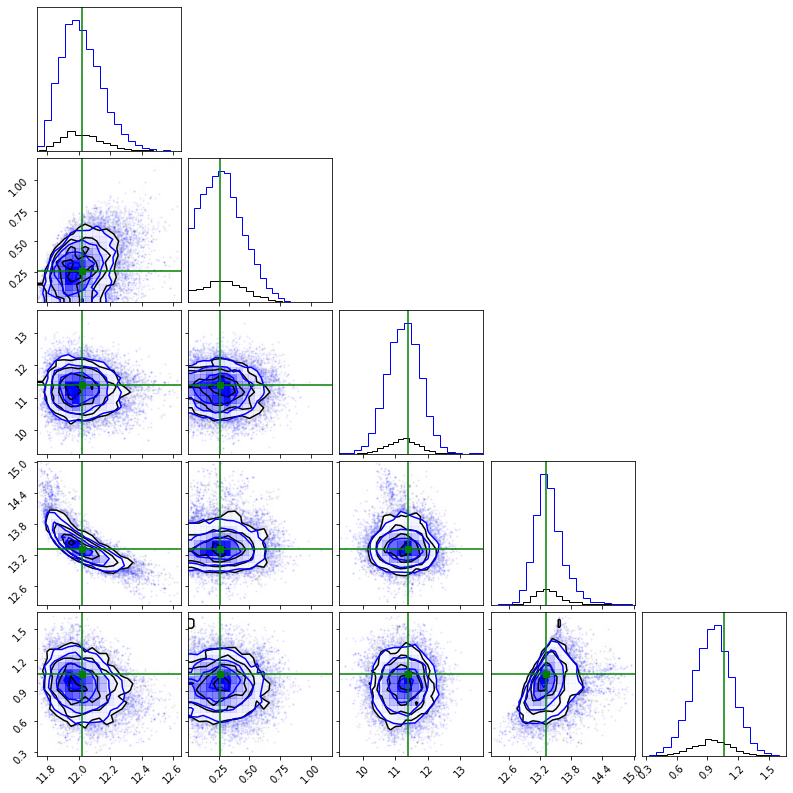

In [53]:
figure = corner.corner(np.array(q[:,:,:]).reshape(-1,5)[:],smooth=0.5);
corner.corner(np.array(mcmc[:,100:,:]).reshape(-1,5)[::4], color="blue", fig=figure,);
value1 = [12.02, 0.26, 11.38, 13.31, 1.06] #true values
ndim = 5
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")

In [98]:
#chain 2
np.save("HMC_Samples_5D_102122b.npy",np.array(q[:,:,:]))